# Лабораторная работа по Relevance Vector Regression
В рамках этой лабораторной работы необходимо:
- Имплементировать Relevance Vector Regression
- Применить на синетическом датасете (восстановление полинома), сравнить с Lasso из sklearn и гребневой регрессией
- Применить на данных sinc с RBF признаками, визуализировать "релевантные вектора", сравнить с Support Vector Regression и Lasso
- Сделать выводы

In [1]:
from typing import Tuple

import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import RidgeCV, LassoCV
from tqdm.auto import trange

%matplotlib inline

In [2]:
np.random.seed(123)

In [3]:
def l2_error(X, t, w):
    return np.sum((X.dot(w.ravel()) - t) ** 2)

## Имплементация Relevance Vector Regression

Здесь необходимо реализовать три функции:

1. `get_w_sigma(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и возвращает параметры апостериорного распределения mu, sigma
2. `update_alpha_beta(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и делает один шаг итерационной процедуры для обновления гиперпараметров (было на лекции)
3. `fit_rvr(X, t, max_iters)`, которая принимает датасет (X, t) и максимальное количество итераций и возвращает обученные гиперпараметры и параметры апостериорного распределения на веса модели

На что стоит обратить внимание:

1. Результаты дорогостоящих операций типа перемножения одних и тех же матриц нужно кешировать и переиспользовать
2. $\alpha$-ы для нерелевантных объектов должны принять значение `np.inf`, а соответствующие веса и их дисперсии должны иметь значение 0
3. Бесконечности и нули из предыдущего пункта должны обрабатываться корректно, без NaN-ов и warning-ов
4. Матрицу с бесконечными элементами на диагонали можно обращать более эффективно (достаточно обратить подматрицу)

In [4]:
class RelevanceVectorRegression:
    """Relevance vector machine
    Useful implementation links:
        - http://www.machinelearning.ru/wiki/index.php?title=RVM
        - https://disk.yandex.ru/i/RyxlGTJMqberDQ
        - https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/ace_chapter9_2019.pdf
    """

    def __init__(self, alpha_bound: float = 1e12, weight_bound: float = 1e-6):
        self.__alpha_bound = alpha_bound
        self.__weight_bound = weight_bound
        self.__cache = {}

    def __fit_cache(self, X: np.ndarray, t: np.ndarray):
        self.__cache = {}
        XT = X.T
        self.__cache["XTX"] = XT @ X
        self.__cache["XTt"] = XT @ t

    def _get_mu_sigma(
        self, X: np.ndarray, t: np.ndarray, alpha: np.ndarray, beta: float
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Calculate the mean and the covariance matrix of the posterior distribution.

        p(w | X, t, alpha, beta) = N(w | mu, sigma)
        sigma = (beta X^T X + A)^{-1}
        mu = beta sigma X^T t
        """
        n, d = X.shape
        XTX = self.__cache.get("XTX", X.T @ X)
        XTt = self.__cache.get("XTt", X.T @ t)

        mask = alpha < self.__alpha_bound

        sigma_inverse = beta * XTX[mask][:, mask]
        sigma_inverse[np.diag_indices_from(sigma_inverse)] += alpha[mask]

        sigma = np.linalg.inv(sigma_inverse)

        sigma_diag = np.zeros(d)
        sigma_diag[mask] = np.diag(sigma)

        mu = np.zeros(d)
        mu[mask] = beta * sigma.dot(XTt[mask])

        return mu, sigma_diag

    def _update_alpha_beta(
        self, X: np.ndarray, t: np.ndarray, alpha: np.ndarray, beta: float
    ) -> Tuple[np.ndarray, float]:
        """Update the hyperparemeters to increase evidence.

        w_j < weight bound or a_j > alpha bound => w_j = 0, a_j = inf
        else => a_j = (1 - a_j sigma_j) / w_j^2

        b_i = n - sum(1 - a_j sigma_j) / ||X w - t||_2
        """
        n, d = X.shape
        mu, sigma = self._get_mu_sigma(X, t, alpha, beta)

        mask = (alpha < self.__alpha_bound) & (abs(mu) > self.__weight_bound)
        mu[~mask] = 0

        y = 1 - alpha[mask] * sigma[mask]

        alpha_new = np.full(d, np.inf)
        alpha_new[mask] = y / (mu[mask] ** 2)

        beta_new = (n - y.sum()) / ((X.dot(mu) - t) ** 2).sum()

        return alpha_new, beta_new

    def fit(
        self, X: np.ndarray, t: np.ndarray, max_iter: int = 10000
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, float]:
        """Train the Relevance Vector Regression model."""
        self.__fit_cache(X, t)
        n, d = X.shape

        alpha = np.ones(d)
        beta = 1.0

        for _ in trange(max_iter, desc="Fit RVR"):
            alpha, beta = self._update_alpha_beta(X, t, alpha, beta)

        mu, sigma = self._get_mu_sigma(X, t, alpha, beta)
        return mu, sigma, alpha, beta

## Восстановление полинома

Здесь решается модельная задача: зашумленным полиномом третьей степени сгенерированы данные для задачи регрессии. Нужно на этих данных обучить многочлен степени, не превышающей 20. Предлагается сравнить три модели: гребневую регрессию, L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных признаков.

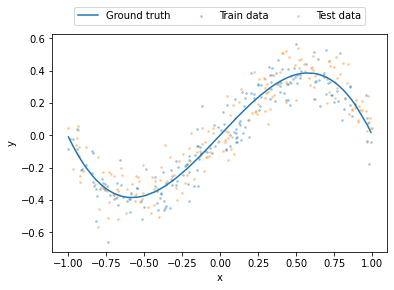

In [5]:
# Data generation


def gen_batch(n, w, beta):
    d = len(w)
    X = np.random.uniform(-1, 1, (n, 1))
    X = np.sort(X, axis=0)
    X = np.hstack([X ** i for i in range(d)])
    t = X.dot(w) + np.random.normal(size=n) / beta ** 0.5
    return X, t


n = 200
d = 21
w_true = np.zeros(d)
w_true[1] = 1
w_true[3] = -1
beta_true = 100

X_train, t_train = gen_batch(n, w_true, beta_true)
X_test, t_test = gen_batch(n, w_true, beta_true)

# Visualization
fig, ax = plt.subplots()
ax.scatter(X_train[:, 1], t_train, s=3, label="Train data", alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label="Test data", alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label="Ground truth")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [6]:
%%time
# Relevance Vector Regression
rvr = RelevanceVectorRegression()
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = rvr.fit(X_train, t_train)

Fit RVR:   0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 5.77 s, sys: 1.36 s, total: 7.14 s
Wall time: 2.33 s


In [7]:
%%time
# Ridge Regression with Cross-Validation
ridge = RidgeCV(cv=20, alphas=10.0 ** np.linspace(-6, 3, 100), fit_intercept=False).fit(X_train, t_train)
w_ridge = ridge.coef_

CPU times: user 2.87 s, sys: 65.9 ms, total: 2.94 s
Wall time: 2.73 s


In [8]:
%%time
# Lasso Regression with Cross-Validation
lasso = LassoCV(cv=5, alphas=10.0 ** np.linspace(-6, 3, 100), fit_intercept=False, max_iter=2000000).fit(
    X_train, t_train
)
w_lasso = lasso.coef_

CPU times: user 4.78 s, sys: 23.4 ms, total: 4.8 s
Wall time: 4.81 s


/Users/Egor.Spirin/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0069097918335701, tolerance: 0.0012854460800422094
  model = cd_fast.enet_coordinate_descent_gram(


Relevance Vector Regression
Features remaining: 3 / 21
Train error: 0.009052796709304888
Test error:  0.009793464126595342
--------------------------------------------------
Ridge Regression
Features remaining: NA (no sparsity)
Train error: 0.009095034553223615
Test error:  0.00996144205308367
--------------------------------------------------
Lasso Regression
Features remaining: 9 / 21
Train error: 0.008878963547469502
Test error:  0.010139505424318313


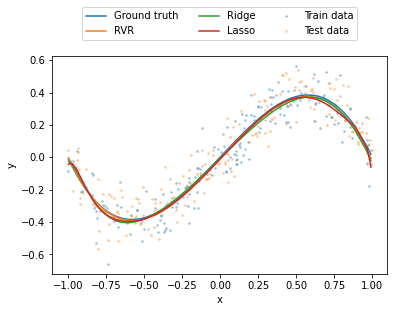

In [9]:
# Comparison
print("Relevance Vector Regression")
print("Features remaining:", np.sum(alpha_rvr < 1e8), "/", d)
print("Train error:", l2_error(X_train, t_train, w_rvr) / n)
print("Test error: ", l2_error(X_test, t_test, w_rvr) / n)
print("-" * 50)
print("Ridge Regression")
print("Features remaining: NA (no sparsity)")
print("Train error:", l2_error(X_train, t_train, w_ridge) / n)
print("Test error: ", l2_error(X_test, t_test, w_ridge) / n)
print("-" * 50)
print("Lasso Regression")
print("Features remaining:", np.sum(np.abs(w_lasso) > 1e-20), "/", d)
print("Train error:", l2_error(X_train, t_train, w_lasso) / n)
print("Test error: ", l2_error(X_test, t_test, w_lasso) / n)

fig, ax = plt.subplots()
ax.scatter(X_train[:, 1], t_train, s=3, label="Train data", alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label="Test data", alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label="Ground truth")
ax.plot(X_train[:, 1], X_train.dot(w_rvr), label="RVR")
ax.plot(X_train[:, 1], X_train.dot(w_ridge), label="Ridge")
ax.plot(X_train[:, 1], X_train.dot(w_lasso), label="Lasso")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Регрессия с RBF-признаками

Здесь решается другая модельная задача: необходимо восстановить зашумленную функцию `sinc(x)`. Предлагается применить kernel trick с RBF-ядром (можно использовать функцию `sklearn.metrics.pairwise.rbf_kernel`), обучить три модели: SVM-регрессию (SVR), L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных опорных / релевантных объектов.

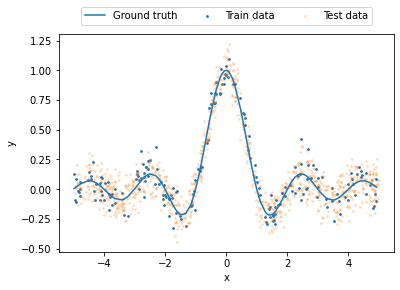

In [10]:
# Data generation
from sklearn.metrics.pairwise import rbf_kernel


def gen_batch(n, beta):
    points = np.random.uniform(-5, 5, n)
    points = np.sort(points)
    t = np.sinc(points) + np.random.normal(size=n) / beta ** 0.5
    return points, t


n = 200
n_test = 1000
d = n + 1
beta_true = 100

points_train, t_train = gen_batch(n, beta_true)
points_test, t_test = gen_batch(n_test, beta_true)

# RBF-transform
X_train = rbf_kernel(points_train.reshape(-1, 1))
X_test = rbf_kernel(points_test.reshape(-1, 1), points_train.reshape(-1, 1))

# Constant feature
X_train = np.hstack((np.ones((n, 1)), X_train))
X_test = np.hstack((np.ones((n_test, 1)), X_test))

# Visualization
fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label="Train data", alpha=1)
ax.scatter(points_test, t_test, s=3, label="Test data", alpha=0.2)
ax.plot(points_train, np.sinc(points_train), label="Ground truth")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [11]:
%%time
# Relevance Vector Regression
rvr = RelevanceVectorRegression()
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = rvr.fit(X_train, t_train)

Fit RVR:   0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 22.5 s, sys: 4.98 s, total: 27.5 s
Wall time: 3.58 s


In [12]:
%%time
# Lasso Regression with Cross-Validation
lasso = LassoCV(
    cv=10, alphas=10.0 ** np.linspace(-5, 1, 20), fit_intercept=False, max_iter=100000, tol=1e-2, n_jobs=10
).fit(X_train, t_train)
w_lasso = lasso.coef_

CPU times: user 2.93 s, sys: 2.2 s, total: 5.13 s
Wall time: 432 ms


In [13]:
%%time
# Support Vector Regression
from sklearn.svm import SVR

svr = SVR(gamma=1, tol=1e-6, C=1).fit(points_train.reshape(-1, 1), t_train)

CPU times: user 28.9 ms, sys: 14 ms, total: 42.9 ms
Wall time: 5.43 ms


Relevance Vector Regression
Objects remaining: 8 / 200
Train error: 0.007990587212897284
Test error:  0.054087883258004614
--------------------------------------------------
Lasso Regression
Objects remaining: 63 / 200
Train error: 0.00944793599324124
Test error:  0.057053745050616646
--------------------------------------------------
Support Vector Regression
Objects remaining: 59 / 200
Train error: 0.008025458610972388
Test error:  0.05380995575776096


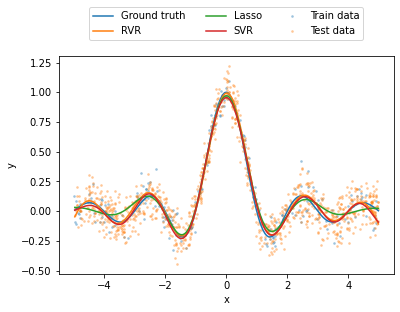

In [14]:
# Comparison
print("Relevance Vector Regression")
print("Objects remaining:", np.sum(alpha_rvr[1:] < 1e8), "/", n)
print("Train error:", l2_error(X_train, t_train, w_rvr) / n)
print("Test error: ", l2_error(X_test, t_test, w_rvr) / n)
print("-" * 50)
print("Lasso Regression")
print("Objects remaining:", np.sum(np.abs(w_lasso[1:]) > 1e-20), "/", n)
print("Train error:", l2_error(X_train, t_train, w_lasso) / n)
print("Test error: ", l2_error(X_test, t_test, w_lasso) / n)
print("-" * 50)
print("Support Vector Regression")
print("Objects remaining:", len(svr.support_), "/", n)
print("Train error:", np.sum((svr.predict(points_train.reshape(-1, 1)) - t_train) ** 2) / n)
print("Test error: ", np.sum((svr.predict(points_test.reshape(-1, 1)) - t_test) ** 2) / n)

fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label="Train data", alpha=0.3)
ax.scatter(points_test, t_test, s=3, label="Test data", alpha=0.3)
ax.plot(points_test, np.sinc(points_test), label="Ground truth")
ax.plot(points_test, X_test.dot(w_rvr), label="RVR")
ax.plot(points_test, X_test.dot(w_lasso), label="Lasso")
ax.plot(points_test, svr.predict(points_test.reshape(-1, 1)), label="SVR")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

### Визуализация релевантных объектов для RVR

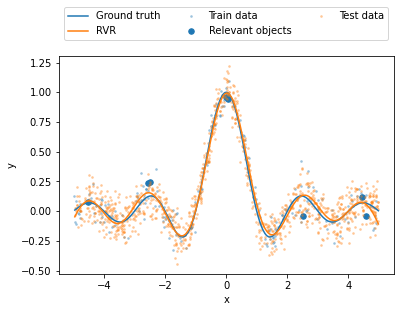

In [15]:
relevant = alpha_rvr[1:] < 1e8
fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label="Train data", alpha=0.3)
ax.scatter(points_train[relevant], t_train[relevant], c="tab:blue", s=30, label="Relevant objects")
ax.scatter(points_test, t_test, s=3, label="Test data", alpha=0.3)
ax.plot(points_test, np.sinc(points_test), label="Ground truth")
ax.plot(points_test, X_test.dot(w_rvr), label="RVR")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Выводы

В обоих проведённых экспериментах, удалось достичь меньшей ошибки на тестовой выборке используя именно RVR.
Хотя разница очень незначительна, вполне возможно другой сид псевдослучайных чисел поменяет порядок.

С другой стороны, используя RVR удалось достичь максимальной разряженности итоговых параметров.
Однако RVR показывает сравнительно небольшую скорость обучения.
